# Assignment 5: Model Interpretability
-----------------------------------
**Your Name Here:Hyun Kyoung Baik (hkb22001)**

You previously worked with this dataset on the 'Sampling' notebooks. Now, you will try to interpret the model!

You will build a classification model of your choice (you may use SMOTE or not - I'm not testing how good your model is for this assignment, just that you know how to interpret the model!). 

Then you will:
* Print the Top 5 features (using permutation importance with 20 repeats) in a box plot.
* Create the partial dependence plots for the top 5 features (you may opt to use the num_grid_points argument). Customize the plots so that the Y axis is consistent on each of the five plots.
* Write five meaningful bullets about what you see in the plots. Does anything surprise you? What do the X and Y axis mean in each plot? 
  * Optional: Any issues with correlated predictors (read here for a cool way on how to address this: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html)?

### Import Module

In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.inspection import permutation_importance

!pip install pulp 
!pip install pycebox
from pycebox.ice import ice, ice_plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Read dataset

In [29]:
#https://drive.google.com/file/d/1CppeqGbiBzX61jx56gcXyGGDNEeLlJ-W/view?usp=share_link
!gdown 1CppeqGbiBzX61jx56gcXyGGDNEeLlJ-W

Downloading...
From: https://drive.google.com/uc?id=1CppeqGbiBzX61jx56gcXyGGDNEeLlJ-W
To: /content/train_loan_imbalanced.csv
100% 38.0k/38.0k [00:00<00:00, 41.4MB/s]


In [30]:
df = pd.read_csv('/content/train_loan_imbalanced.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [31]:
# explore the dataset: Check the types and the number of missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [32]:
df.isna().sum() 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [33]:
#Since there are some missing values, I will remove them. 
df=df.dropna()

In [34]:
# Because 'Loan_ID' is a feature that has unique value identifying each row and the type is also object, I removed it. 
df.drop('Loan_ID', axis=1, inplace=True)
df.shape  

(480, 12)

In [35]:
# Recode the object types of features 

df['Gender']=np.where(df['Gender']=='Male',1,0) 
df['Married']=np.where(df['Married']=='Yes',1,0)
df['Dependents']=np.where(df['Dependents']==1,1,0)
df['Education']=np.where(df['Education']=='Graduate',1,0)
df['Self_Employed']=np.where(df['Self_Employed']=='Yes',1,0)
df['Property_Area']=np.where(df['Property_Area']=='Urban',1,0)
df['Loan_Status']=np.where(df['Loan_Status']=='Y',1,0)

In [36]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,1,1,0,1,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,1,1
3,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,1,1
4,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,1,1
5,1,1,0,1,1,5417,4196.0,267.0,360.0,1.0,1,1


### ML modeling 

#### Split X and y, and sampling


In [37]:
X=df.drop('Loan_Status', axis=1)
y=df['Loan_Status']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=123)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(384, 11) (384,) (96, 11) (96,)


In [38]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
364,1,0,0,1,1,6822,0.0,141.0,360.0,1.0,0
354,0,1,0,1,0,2423,505.0,130.0,360.0,1.0,0
169,1,1,0,1,0,8000,0.0,200.0,360.0,1.0,0
441,1,1,0,1,0,7901,1833.0,180.0,360.0,1.0,0
26,1,1,0,1,0,2799,2253.0,122.0,360.0,1.0,0


#### Scaling dataset

In [39]:
scaler=MinMaxScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [40]:
tmp=pd.DataFrame(X_train)
tmp.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,384.000000,384.000000,384.0,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000
mean,0.825521,0.643229,0.0,0.799479,0.135417,0.057135,0.050861,0.231070,0.691371,0.867188,0.322917
std,0.380016,0.479671,0.0,0.400912,0.342614,0.070052,0.083834,0.133196,0.140616,0.339815,0.468201
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.0,1.000000,0.000000,0.026650,0.000000,0.156937,0.729730,1.000000,0.000000
50%,1.000000,1.000000,0.0,1.000000,0.000000,0.038871,0.038419,0.203046,0.729730,1.000000,0.000000
75%,1.000000,1.000000,0.0,1.000000,0.000000,0.064713,0.070965,0.277496,0.729730,1.000000,1.000000
max,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Fit the model: Random Forest Classifier

In [41]:
RFC=RandomForestClassifier(min_samples_split=10)
RFC=RFC.fit(X_train,y_train)

In [42]:
train_preds_RFC=RFC.predict(X_train)
test_preds_RFC=RFC.predict(X_test)

#### Model evaluation


In [43]:
print('[Confusion Matix]','\n')
print('Train RFC: ''\n' )
print(confusion_matrix(y_train,train_preds_RFC),'\n')
print('Test RFC: ' '\n')
print(confusion_matrix(y_test,test_preds_RFC),'\n','\n')

print('[Classification Report]','\n')
TrainReport_RFC=classification_report(y_train,train_preds_RFC)
print('Train Report: \n',TrainReport_RFC,'\n')
TestReport_RFC=classification_report(y_test,test_preds_RFC)
print('Test Report: \n',TestReport_RFC)

[Confusion Matix] 

Train RFC: 

[[ 71  41]
 [  6 266]] 

Test RFC: 

[[20 16]
 [ 4 56]] 
 

[Classification Report] 

Train Report: 
               precision    recall  f1-score   support

           0       0.92      0.63      0.75       112
           1       0.87      0.98      0.92       272

    accuracy                           0.88       384
   macro avg       0.89      0.81      0.84       384
weighted avg       0.88      0.88      0.87       384
 

Test Report: 
               precision    recall  f1-score   support

           0       0.83      0.56      0.67        36
           1       0.78      0.93      0.85        60

    accuracy                           0.79        96
   macro avg       0.81      0.74      0.76        96
weighted avg       0.80      0.79      0.78        96



### Permutation importance : Top 5 features


In [44]:
clf_RFC = RFC
result = permutation_importance(clf_RFC, X_test, y_test, n_repeats=20,
                                random_state=123)
perm_sorted_idx = result.importances_mean.argsort()

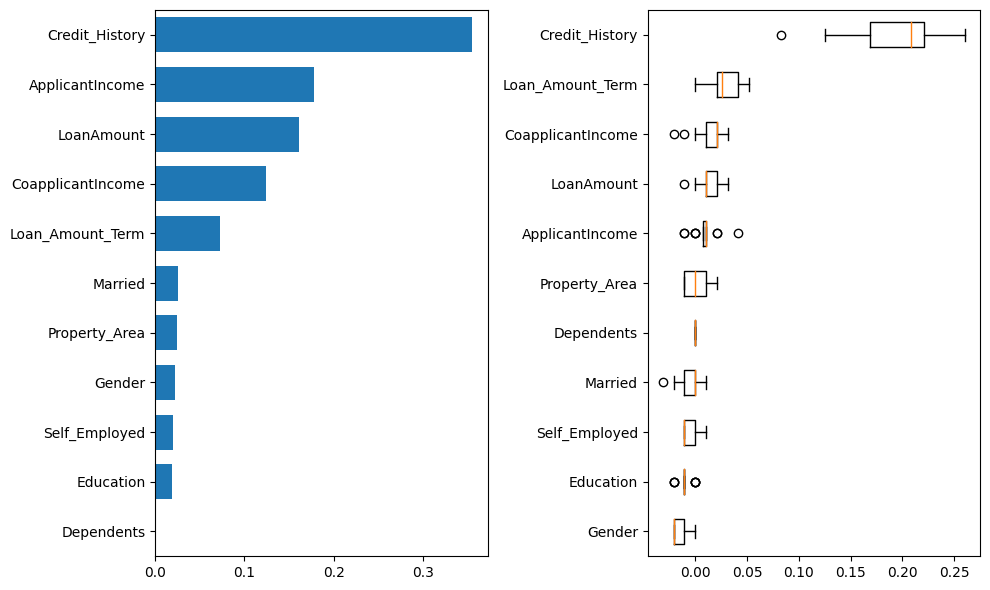

In [45]:
tree_importance_sorted_idx = np.argsort(clf_RFC.feature_importances_)
tree_indices = np.arange(0, len(clf_RFC.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.barh(tree_indices, clf_RFC.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(df.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf_RFC.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=df.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

Using permutation importance, we find five features that influence the loan amount status. Of these, you can see that Credit History is the feature that has the greatest impact on the Loan Amount outcome. 

***- Top 5 feature:  Credic_History, ApplicaniIncome, Loan_Amount_Term, LoanAmount, CoapplicantIncome***

### Partial Dependence Plot 


In [46]:
X_train_df=pd.DataFrame(X_train,columns=X.columns)
X_train_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1.0,0.0,0.0,1.0,1.0,0.076871,0.000000,0.223350,0.72973,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.022127,0.014924,0.204738,0.72973,1.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.091531,0.000000,0.323181,0.72973,1.0,0.0
3,1.0,1.0,0.0,1.0,0.0,0.090299,0.054171,0.289340,0.72973,1.0,0.0
4,1.0,1.0,0.0,1.0,0.0,0.026806,0.066584,0.191201,0.72973,1.0,0.0


In [47]:
print(X_train_df.shape)

(384, 11)


In [48]:
X_train_df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
count,384.000000,384.000000,384.0,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000
mean,0.825521,0.643229,0.0,0.799479,0.135417,0.057135,0.050861,0.231070,0.691371,0.867188,0.322917
std,0.380016,0.479671,0.0,0.400912,0.342614,0.070052,0.083834,0.133196,0.140616,0.339815,0.468201
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.0,1.000000,0.000000,0.026650,0.000000,0.156937,0.729730,1.000000,0.000000
50%,1.000000,1.000000,0.0,1.000000,0.000000,0.038871,0.038419,0.203046,0.729730,1.000000,0.000000
75%,1.000000,1.000000,0.0,1.000000,0.000000,0.064713,0.070965,0.277496,0.729730,1.000000,1.000000
max,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
print('The number of unique value from credit_History: ',X_train_df['Credit_History'].nunique())
print('The number of unique value from LoanAmount: ',X_train_df['LoanAmount'].nunique())
print('The number of unique value from CoapplicantIncome: ',X_train_df['CoapplicantIncome'].nunique())
print('The number of unique value from ApplicantIncome: ',X_train_df['ApplicantIncome'].nunique())
print('The number of unique value from Loan_Amount_Term: ',X_train_df['Loan_Amount_Term'].nunique())

The number of unique value from credit_History:  2
The number of unique value from LoanAmount:  170
The number of unique value from CoapplicantIncome:  191
The number of unique value from ApplicantIncome:  331
The number of unique value from Loan_Amount_Term:  9


#### Credit History


(2, 384)


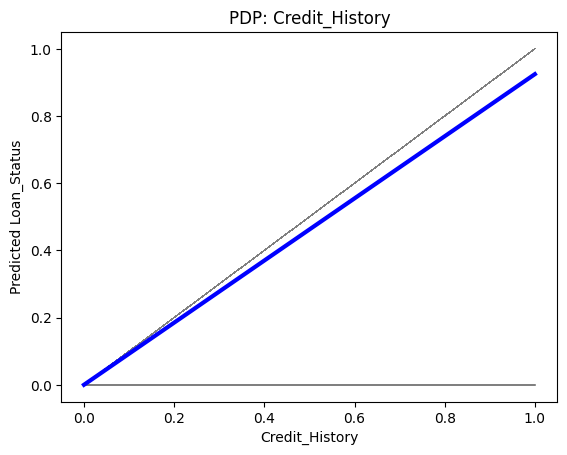

In [50]:
CH=ice(data=X_train_df, 
       column='Credit_History',predict=RFC.predict)
print(np.shape(CH))

ice_plot(CH, c='gray', linewidth=0.3,
                  plot_pdp=True, 
         pdp_kwargs={'linewidth': 3, 'color':'blue'})
plt.title('PDP: Credit_History')
plt.ylabel('Predicted Loan_Status')
plt.xlabel('Credit_History');
plt.show()

#### Loan Amount


(170, 384)


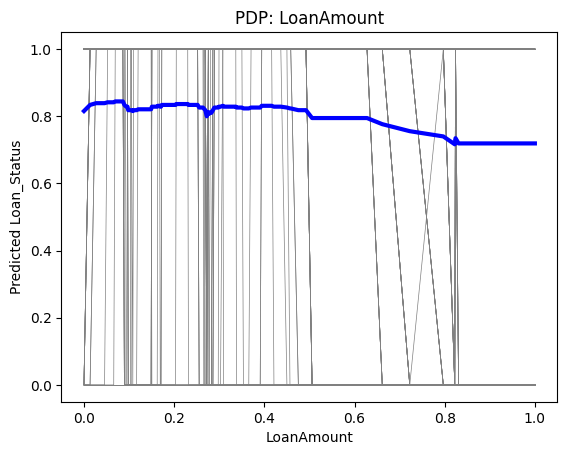

In [51]:
LA=ice(data=X_train_df, 
       column='LoanAmount',predict=RFC.predict)
print(np.shape(LA))

ice_plot(LA, c='gray', linewidth=0.5,
                  plot_pdp=True, 
         pdp_kwargs={'linewidth': 3, 'color':'blue'})
plt.title('PDP: LoanAmount')
plt.ylabel('Predicted Loan_Status')
plt.xlabel('LoanAmount');
plt.show()

####Coapplicant Income

(191, 384)


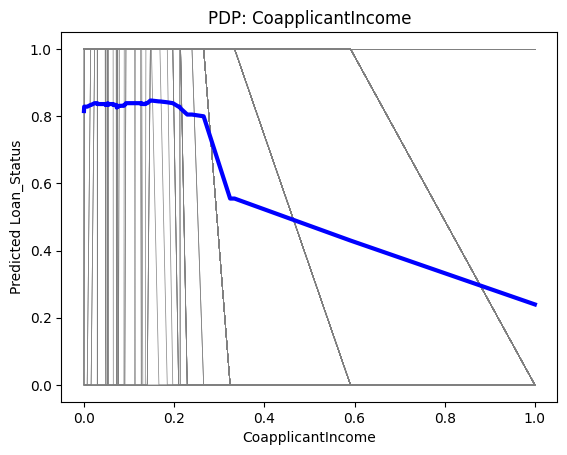

In [52]:
CI=ice(data=X_train_df, column='CoapplicantIncome',predict=RFC.predict)
print(np.shape(CI))

ice_plot(CI, c='gray', linewidth=0.5,
                  plot_pdp=True, 
         pdp_kwargs={'linewidth': 3, 'color':'blue'})
plt.title('PDP: CoapplicantIncome')
plt.ylabel('Predicted Loan_Status')
plt.xlabel('CoapplicantIncome');
plt.show()

####Applicant Income

(331, 384)


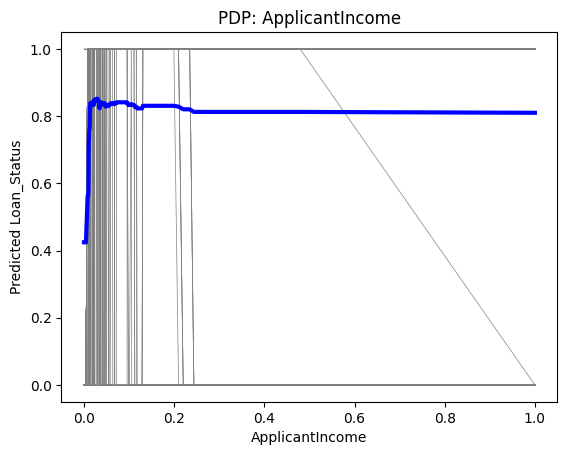

In [53]:
AC=ice(data=X_train_df, 
       column='ApplicantIncome',predict=RFC.predict)
print(np.shape(AC))

ice_plot(AC, c='gray', linewidth=0.5,
                  plot_pdp=True, 
         pdp_kwargs={'linewidth': 3, 'color':'blue'})
plt.title('PDP: ApplicantIncome')
plt.ylabel('Predicted Loan_Status')
plt.xlabel('ApplicantIncome');
plt.show()

#### Loan Amount Term


(9, 384)


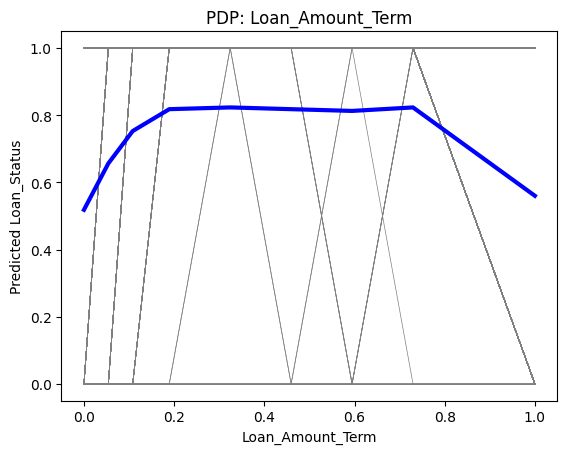

In [54]:
LAT=ice(data=X_train_df, 
       column='Loan_Amount_Term',predict=RFC.predict)
print(np.shape(LAT))

ice_plot(LAT, c='gray', linewidth=0.5,
                  plot_pdp=True, 
         pdp_kwargs={'linewidth': 3, 'color':'blue'})
plt.title('PDP: Loan_Amount_Term')
plt.ylabel('Predicted Loan_Status')
plt.xlabel('Loan_Amount_Term');
plt.show()

### Interpretation 


In these graphs, X-axis means the each feature, and Y axis means predicted Loan_Status. Each graph represents the relationship between each feature(Credit history, LoanAmount, CoapplicantIncome, ApplicantIncome, and Loan_amount_term) and expected loan_status. I was surprised that the amount of applicant income they earn has no significant impact on the loan status.  
- The values for **credit history** are 0 and 1. According to this PDP, customers with a credit history are expected to have a current or previous loan.  
-Regarding the **LoanAmount**, the overall loan status is stabilized at close to 1. This means that once the applicant has a loan regardless of the amount of loan, its loan status is expected to be 'Y'
- According to the **CoapplicantIncome** plot in PDP, the lower the Coapplicant Income, the more likely it is that a loan will be made. Higher Coapplicant Income is expected to result in fewer loans than lower Coapplicant Income, meaning that applicants with higher Coapplicant Income tend to receive fewer loans.  
- However, **ApplicantIncome** shows a slightly different result. If you look at the graph of applicant income, you can see that it increases sharply as soon as the applicant has income and then stabilizes. This suggests that it's not so much how much an applicant earns, but whether they have any income at all. 
- Looking at the PDP for **Loan_Amount_Term**, we see that loan status increases in the short term and then decreases in the long term, but remains stable over the entire period.